In [1]:
import os

import pandas as pd
import xgboost as xgb

c:\Users\rstee\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import shap
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=1): # RS_ agregar lag
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    i=1
    while i <= lag:    
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        # gb_df_[f"{new_name}_ma3{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i).rolling(window = 3).mean())
        i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    
    return dfst

In [4]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ventassem.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [5]:
df = pd.read_csv(TRAIN_CSV_PATH)
df.head(5)

,id,item,category,department,store_code,region,yearweek,Cantidad,sell_price,event
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,0,12.7414,0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,0,12.7414,1
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,0,12.7414,0
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,0,12.7414,0
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,0,12.7414,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476220 entries, 0 to 8476219
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item        int64  
 2   category    int64  
 3   department  int64  
 4   store_code  int64  
 5   region      int64  
 6   yearweek    int64  
 7   Cantidad    int64  
 8   sell_price  float64
 9   event       int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 646.7+ MB


In [7]:
df["id"].nunique()

30490

In [9]:
sample="ACCESORIES_1_001_BOS_1"

In [10]:
df[df["id"] == sample]

,id,item,category,department,store_code,region,yearweek,Cantidad,sell_price,event
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,0,12.7414,0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,0,12.7414,1
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,0,12.7414,0
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,0,12.7414,0
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,0,12.7414,0
...,...,...,...,...,...,...,...,...,...,...
273,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201616,4,10.9858,0
274,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201617,0,10.9858,0
275,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201618,0,10.9858,0
276,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201619,0,10.9858,0


In [11]:
df["item"].nunique()

3049

In [12]:
df["Cantidad"].sum()

65695409

In [13]:
MIN_DATE = df["yearweek"].min()
MAX_DATE = df["yearweek"].max()

In [14]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 201104
Max date is 201620


In [15]:
df.isnull().sum()

id            0
item          0
category      0
department    0
store_code    0
region        0
yearweek      0
Cantidad      0
sell_price    0
event         0
dtype: int64

In [16]:
df.sort_values(["id", "yearweek"], ascending = True, inplace = True)

<a id='train_test_split'></a>
### Train Test Split


In [17]:
df.columns.tolist()

['id',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'yearweek',
 'Cantidad',
 'sell_price',
 'event']

In [18]:
COLUMNS_TO_DROP = [
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [19]:
df.set_index("id", inplace = True)

In [20]:
df.head()

,item,category,department,store_code,region,yearweek,Cantidad,sell_price,event
id,,,,,,,,,
ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,0,12.7414,1
ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,0,12.7414,0


In [21]:
df["Cantidad"].sum()

65695409

In [22]:
df.shape

(8476220, 9)

In [23]:
train_index = sorted(list(df["yearweek"].unique()))[:-8]

valida_index = sorted(list(df["yearweek"].unique()))[-8:-4]

test_index = sorted(list(df["yearweek"].unique()))[-4:]


In [24]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [201104, 201105] - ... - [201611, 201612]

Our validation index is [201613, 201614, 201615, 201616]

Our test/prediction index is [201617, 201618, 201619, 201620]



In [25]:
X_train = df[df["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = df[df["yearweek"].isin(train_index)]["Cantidad"]

X_valida = df[df["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = df[df["yearweek"].isin(valida_index)]["Cantidad"]

X_test = df[df["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
Y_test = df[df["yearweek"].isin(test_index)]["Cantidad"]

In [26]:
X_train.head()

,item,category,department,store_code,region,sell_price,event
id,,,,,,,
ACCESORIES_1_001_BOS_1,0,0,0,0,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,12.7414,1
ACCESORIES_1_001_BOS_1,0,0,0,0,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,12.7414,0
ACCESORIES_1_001_BOS_1,0,0,0,0,0,12.7414,0


### Model Train

In [27]:
model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)

model.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
        verbose = True
        ,early_stopping_rounds=15
        )

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:23.17094	validation_1-rmse:21.72452
[1]	validation_0-rmse:22.26383	validation_1-rmse:20.60772
[2]	validation_0-rmse:21.81484	validation_1-rmse:20.05024
[3]	validation_0-rmse:21.52595	validation_1-rmse:19.65131
[4]	validation_0-rmse:21.33794	validation_1-rmse:19.32578
[5]	validation_0-rmse:21.20506	validation_1-rmse:19.19712
[6]	validation_0-rmse:21.08346	validation_1-rmse:19.04687
[7]	validation_0-rmse:21.01821	validation_1-rmse:19.00018
[8]	validation_0-rmse:20.95835	validation_1-rmse:18.91912
[9]	validation_0-rmse:20.87675	validation_1-rmse:18.84405
[10]	validation_0-rmse:20.83281	validation_1-rmse:18.80632
[11]	validation_0-rmse:20.80872	validation_1-rmse:18.77998
[12]	validation_0-rmse:20.78505	validation_1-rmse:18.77200
[13]	validation_0-rmse:20.76268	validation_1-rmse:18.75231
[14]	validation_0-rmse:20.73716	validation_1-rmse:18.72711
[15]	validation_0-rmse:20.70762	validation_1-rmse:18.69633
[16]	validation_0-rmse:20.68214	validation_1-rmse:18.68428
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, random_state=175, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=175, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None)

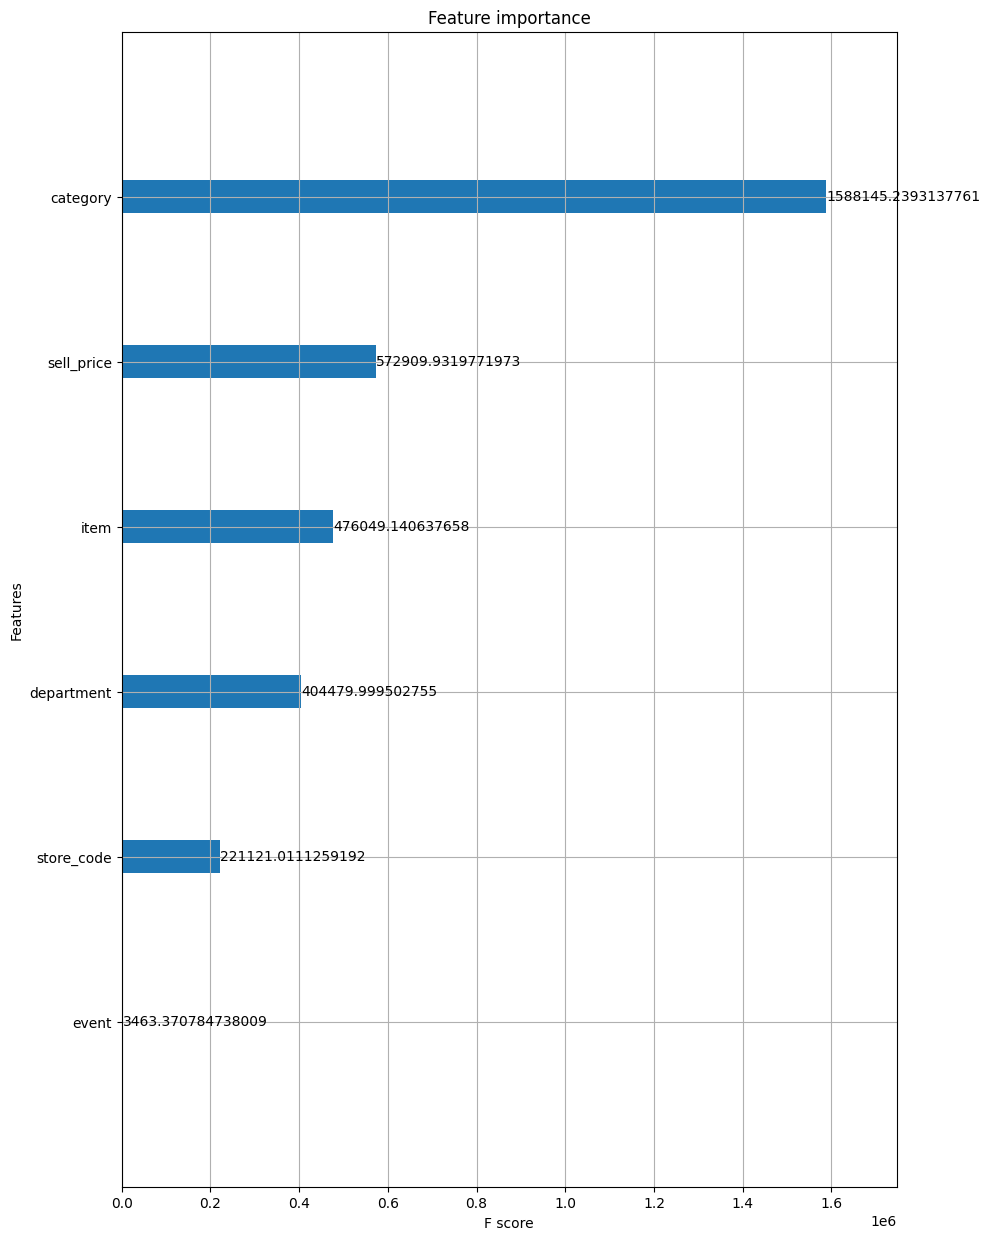

In [28]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [29]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [30]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 19_879
Validation RMSE: 18_084


In [31]:
if "Cantidad" in X_test.columns:
    X_test.drop("Cantidad", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["Cantidad"] = Y_test_predict

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [32]:
X_test.reset_index(inplace = True)

In [33]:
X_test

,id,item,category,department,store_code,region,sell_price,event,Cantidad
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,10.9858,0,2.046523
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,10.9858,0,2.046523
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,10.9858,0,2.046523
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,10.9858,0,2.046523
4,ACCESORIES_1_001_BOS_2,0,0,0,1,0,10.9858,0,2.979243
...,...,...,...,...,...,...,...,...,...
121955,SUPERMARKET_3_827_PHI_2,3048,2,6,8,2,1.2000,0,3.454559
121956,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,1.2000,0,4.824797
121957,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,1.2000,0,4.824797
121958,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,1.2000,0,4.824797


In [99]:
train_index = sorted(list(df["yearweek"].unique()))[:-5]
valida_index = [sorted(list(df["yearweek"].unique()))[-5]]

X_train = df[df["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = df[df["yearweek"].isin(train_index)]["Cantidad"]

X_valida = df[df["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = df[df["yearweek"].isin(valida_index)]["Cantidad"]

In [102]:
Y_valida

id
ACCESORIES_1_001_BOS_1      4
ACCESORIES_1_001_BOS_2      1
ACCESORIES_1_001_BOS_3      0
ACCESORIES_1_001_NYC_1      8
ACCESORIES_1_001_NYC_2     10
                           ..
SUPERMARKET_3_827_NYC_3    38
SUPERMARKET_3_827_NYC_4    22
SUPERMARKET_3_827_PHI_1    15
SUPERMARKET_3_827_PHI_2    12
SUPERMARKET_3_827_PHI_3     0
Name: Cantidad, Length: 30490, dtype: int64

In [109]:
train_index = sorted(list(df["yearweek"].unique()))[:-5]
valida_index = [sorted(list(df["yearweek"].unique()))[-5]]

X_train = df[df["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = df[df["yearweek"].isin(train_index)]["Cantidad"]

X_valida = df[df["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = df[df["yearweek"].isin(valida_index)]["Cantidad"]

for i in range(0,4): 


    test_index = [sorted(list(df["yearweek"].unique()))[i]]
    X_test = df[df["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
    Y_test = df[df["yearweek"].isin(test_index)]["Cantidad"]

    model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)

    model.fit(X_train, Y_train,
        eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
        verbose = True
        ,early_stopping_rounds=15
        )

    Y_train_predict = model.predict(X_train)
    Y_valida_predict = model.predict(X_valida)

    rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
    )

    rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
    )

    rmse_train= str(round(rmse_train, 3)).replace(".", "_")
    rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

    print(f"Train RMSE: {rmse_train}")
    print(f"Validation RMSE: {rmse_valida}")

    Y_test_predict = model.predict(X_test)

    X_train=pd.concat([X_train, X_valida])
    X_valida=X_test.copy()
    Y_train=pd.concat([Y_train, Y_valida])
    Y_valida = Y_valida.replace(Y_valida.values, Y_test_predict)


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:23.15679	validation_1-rmse:20.45636
[1]	validation_0-rmse:22.33833	validation_1-rmse:19.41023
[2]	validation_0-rmse:21.86741	validation_1-rmse:18.75238
[3]	validation_0-rmse:21.54919	validation_1-rmse:18.41143
[4]	validation_0-rmse:21.37295	validation_1-rmse:18.20250
[5]	validation_0-rmse:21.16375	validation_1-rmse:17.95052
[6]	validation_0-rmse:21.08069	validation_1-rmse:17.86498
[7]	validation_0-rmse:21.00038	validation_1-rmse:17.77709
[8]	validation_0-rmse:20.94574	validation_1-rmse:17.72920
[9]	validation_0-rmse:20.88338	validation_1-rmse:17.63497
[10]	validation_0-rmse:20.83256	validation_1-rmse:17.58997
[11]	validation_0-rmse:20.81561	validation_1-rmse:17.59153
[12]	validation_0-rmse:20.79240	validation_1-rmse:17.56282
[13]	validation_0-rmse:20.69163	validation_1-rmse:17.44973
[14]	validation_0-rmse:20.67212	validation_1-rmse:17.43548
[15]	validation_0-rmse:20.61296	validation_1-rmse:17.39773
[16]	validation_0-rmse:20.58913	validation_1-rmse:17.38250
[17]	va

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:23.14933	validation_1-rmse:11.14561
[1]	validation_0-rmse:22.32713	validation_1-rmse:10.59259
[2]	validation_0-rmse:21.85677	validation_1-rmse:10.50214
[3]	validation_0-rmse:21.53932	validation_1-rmse:10.66454
[4]	validation_0-rmse:21.36298	validation_1-rmse:10.85421
[5]	validation_0-rmse:21.15442	validation_1-rmse:10.94337
[6]	validation_0-rmse:21.07161	validation_1-rmse:11.14524
[7]	validation_0-rmse:20.99120	validation_1-rmse:11.26715
[8]	validation_0-rmse:20.93680	validation_1-rmse:11.35927
[9]	validation_0-rmse:20.87422	validation_1-rmse:11.35703
[10]	validation_0-rmse:20.82409	validation_1-rmse:11.48459
[11]	validation_0-rmse:20.80605	validation_1-rmse:11.52823
[12]	validation_0-rmse:20.78289	validation_1-rmse:11.56910
[13]	validation_0-rmse:20.68209	validation_1-rmse:11.54455
[14]	validation_0-rmse:20.66321	validation_1-rmse:11.55983
[15]	validation_0-rmse:20.60371	validation_1-rmse:11.61416
[16]	validation_0-rmse:20.58148	validation_1-rmse:11.62264
[17]	va

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:23.12057	validation_1-rmse:11.19729
[1]	validation_0-rmse:22.30481	validation_1-rmse:10.49612
[2]	validation_0-rmse:21.82775	validation_1-rmse:10.30480
[3]	validation_0-rmse:21.51123	validation_1-rmse:10.40782
[4]	validation_0-rmse:21.33318	validation_1-rmse:10.57327
[5]	validation_0-rmse:21.12758	validation_1-rmse:10.77706
[6]	validation_0-rmse:21.04427	validation_1-rmse:10.98279
[7]	validation_0-rmse:20.96609	validation_1-rmse:11.13541
[8]	validation_0-rmse:20.91272	validation_1-rmse:11.27529
[9]	validation_0-rmse:20.85075	validation_1-rmse:11.31788
[10]	validation_0-rmse:20.80009	validation_1-rmse:11.48029
[11]	validation_0-rmse:20.78261	validation_1-rmse:11.53059
[12]	validation_0-rmse:20.75951	validation_1-rmse:11.58966
[13]	validation_0-rmse:20.65962	validation_1-rmse:11.71794
[14]	validation_0-rmse:20.64083	validation_1-rmse:11.76117
[15]	validation_0-rmse:20.58185	validation_1-rmse:11.84668
[16]	validation_0-rmse:20.56080	validation_1-rmse:11.87116
Train R

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:23.08897	validation_1-rmse:11.16757
[1]	validation_0-rmse:22.27320	validation_1-rmse:10.46412
[2]	validation_0-rmse:21.80549	validation_1-rmse:10.27699
[3]	validation_0-rmse:21.48298	validation_1-rmse:10.38227
[4]	validation_0-rmse:21.30677	validation_1-rmse:10.54748
[5]	validation_0-rmse:21.10233	validation_1-rmse:10.75158
[6]	validation_0-rmse:21.01882	validation_1-rmse:10.95631
[7]	validation_0-rmse:20.95473	validation_1-rmse:11.09748
[8]	validation_0-rmse:20.88276	validation_1-rmse:11.20001
[9]	validation_0-rmse:20.85302	validation_1-rmse:11.28661
[10]	validation_0-rmse:20.82559	validation_1-rmse:11.37876
[11]	validation_0-rmse:20.78359	validation_1-rmse:11.42391
[12]	validation_0-rmse:20.75830	validation_1-rmse:11.49923
[13]	validation_0-rmse:20.73839	validation_1-rmse:11.52707
[14]	validation_0-rmse:20.72364	validation_1-rmse:11.56287
[15]	validation_0-rmse:20.70151	validation_1-rmse:11.62578
[16]	validation_0-rmse:20.63928	validation_1-rmse:11.68437
[17]	va

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
